In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import norm
import pandas as pd
import itertools
from scipy.stats import dirichlet

In [2]:
def EstimateParameters(fixture_list_1, fixture_list_2, fixture_list_3,
                       teams, beta, thetapriormeans, thetapriorsds,
                       niter=1000, log=False, temp=0):
    
    # xdata and ydata are coordinates and y values of data
    # xmodel are coordinates of model evaluations
    # thetaprior are prior guesses for parameters
    
    # draw initial
    if log:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.exp(np.random.normal(thetapriormeans[i], thetapriorsds[i], 1))
        else:
            theta = np.exp(np.random.normal(thetapriormeans, thetapriorsds, 1))
    else:
        if hasattr(thetapriormeans, '__len__'):
            theta = np.zeros(len(thetapriormeans))
            for i in range(len(thetapriormeans)):
                theta[i] = np.random.normal(thetapriormeans[i], thetapriorsds[i], 1)
            # normalize
            #theta[(len(teams) + 1 - 1)] = -np.sum(theta[1:(len(teams) + 1 - 1)])
            #theta[((2 * len(teams)) + 1 - 1)] = -np.sum(theta[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
        else:
            theta = np.random.normal(thetapriormeans, thetapriorsds, 1)
    
    if hasattr(thetapriormeans, '__len__'):
        thetaarray = np.zeros((niter, len(thetapriormeans)))
    else:
        thetaarray = np.zeros(niter)
    
    for j in range(niter):
        
        # temperature
        T = np.exp(-temp * ((i + 1) / niter))
        
        if log:
            if hasattr(thetapriormeans, '__len__'):
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), len(theta)))
            else:
                thetastar = np.exp(np.log(theta) + np.random.normal(0, np.sqrt(beta), 1))
        else:
            if hasattr(thetapriormeans, '__len__'):
                ind = np.random.normal(0, np.sqrt(beta), len(theta))
                # normalize
                #ind[(len(teams) + 1 - 1)] = -np.sum(ind[1:(len(teams) + 1 - 1)])
                #ind[((2 * len(teams)) + 1 - 1)] = -np.sum(ind[(len(teams) + 1):((2 * len(teams)) + 1 - 1)])
                thetastar = theta + ind
            else:
                ind = np.random.normal(0, np.sqrt(beta), 1)
                thetastar = theta + ind
        
        # get likelihood for each
        mu = theta[0]
        a = theta[1:(len(teams) + 1)]
        d = theta[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = theta[((2 * len(teams)) + 1)]
        Htheta = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                          teams, mu, a, d, alpha)
        
        mu = thetastar[0]
        a = thetastar[1:(len(teams) + 1)]
        d = thetastar[(len(teams) + 1):((2 * len(teams)) + 1)]
        alpha = thetastar[((2 * len(teams)) + 1)]
        Hthetastar = likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3,
                                              teams, mu, a, d, alpha)
        
        alpha = np.min([0, (1 / T) * (Hthetastar - Htheta)])
        
        # sample uniformly
        u = np.random.uniform(0, 1)
        
        # accept or not
        accept = np.log(u) <= alpha
        
        if accept:
            theta = thetastar
            
        if hasattr(thetapriormeans, '__len__'):
            thetaarray[j, :] = theta
            if (j%10) == 0:
                print('------')
                print('Iteration: ', str(j))
                print('Home coefficient: '+str(thetaarray[j, 0]))
                print('Arsenal attack coefficient: '+str(thetaarray[j, 1]))
        else:
            thetaarray[j] = theta
    
    return thetaarray

# create likelihood eval for one game
def likelihood_one_game(goals_ht, goals_at, form_ht, form_at, mu, a_ht, d_ht, a_at, d_at, alpha):
    lambda_ht = np.exp(mu + a_ht + d_at + (alpha * form_ht))
    lambda_at = np.exp(a_at + d_ht + (alpha * form_at))
    p1 = poisson.pmf(goals_ht, lambda_ht)
    p2 = poisson.pmf(goals_at, lambda_at)
    return(p1 * p2)

# create form matrix
def find_form(fixtures_list):
    
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    mat_form = np.zeros((N, 2))
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        mat_form[i, 0] = form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht]
        mat_form[i, 1] = form[team_count[ind_for_season_at].astype(int), ind_for_season_at]
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    
    return(teams_for_season, mat_form)

# create likelihood eval for single season
def likelihood_season(fixtures_list, teams, mu, a, d, alpha):
    N = np.shape(fixtures_list)[0]
    goals_ht = fixtures_list[:, 2]
    goals_at = fixtures_list[:, 3]
    teams_ht = fixtures_list[:, 0]
    teams_at = fixtures_list[:, 1]
    
    teams_for_season = np.unique(teams_ht)
    
    points = np.zeros((38, 20))
    team_count = np.zeros(20)
    for i in range(N):
        points[team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] = (3 * (goals_ht[i] > goals_at[i])) + (goals_ht[i] == goals_at[i])
        points[team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)].astype(int), np.where(teams_for_season == teams_at[i])[0][0].astype(int)] = (3 * (goals_ht[i] < goals_at[i])) + (goals_ht[i] == goals_at[i])
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
    form = np.ones((38, 20)) * 7.5
    for j in range(20):
        form[5:, j] = np.cumsum(points[:, j])[5:] - np.cumsum(points[:, j])[:(38 - 5)]
    
    team_count = np.zeros(20)
    likelihood = np.zeros(N)
    for i in range(N):
        ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
        ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
        ind_for_season_ht = np.where(teams_for_season == teams_ht[i])[0][0].astype(int)
        ind_for_season_at = np.where(teams_for_season == teams_at[i])[0][0].astype(int)
        l = likelihood_one_game(goals_ht[i], goals_at[i],
                                form[team_count[ind_for_season_ht].astype(int), ind_for_season_ht].astype(int), form[team_count[ind_for_season_at].astype(int), ind_for_season_at],
                                mu, a[ind_ht], d[ind_ht], a[ind_at], d[ind_at], alpha)
        team_count[np.where(teams_for_season == teams_ht[i])[0][0].astype(int)] += 1
        team_count[np.where(teams_for_season == teams_at[i])[0][0].astype(int)] += 1
        likelihood[i] = l
    
    return(np.sum(np.log(likelihood)))

# likelihood over three seasons - weighted
def likelihood_three_seasons(fixture_list_1, fixture_list_2, fixture_list_3, teams, mu, a, d, alpha):
    likelihood = (0.2 * likelihood_season(fixture_list_1, teams, mu, a, d, alpha)) + (0.3 * likelihood_season(fixture_list_2, teams, mu, a, d, alpha)) + (0.5 * likelihood_season(fixture_list_3, teams, mu, a, d, alpha))
    return(likelihood)

# function to predict probabilities of fixtures
def predict_fixtures(new_fixtures, form, teams, mu, a, d, alpha, uncertainty=False):
    if uncertainty:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            muest = np.random.normal(mu[0], mu[1])
            aest = np.zeros(len(teams))
            dest = np.zeros(len(teams))
            for u in range(len(teams)):
                aest[u] = np.random.normal(a[u, 0], a[u, 1])
                dest[u] = np.random.normal(d[u, 0], d[u, 1])
            alphaest = np.random.normal(alpha[0], alpha[1])
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(muest + aest[ind_ht] + dest[ind_at] + (alphaest * form[i, 0]))
            lambda_2[i] = np.exp(aest[ind_at] + dest[ind_ht] + (alphaest * form[i, 1]))
    else:
        # form is N x 2
        N = np.shape(new_fixtures)[0]
        teams_ht = new_fixtures[:, 0]
        teams_at = new_fixtures[:, 1]
        lambda_1 = np.zeros(N)
        lambda_2 = np.zeros(N)
        for i in range(N):
            ind_ht = np.where(teams == teams_ht[i])[0][0].astype(int)
            ind_at = np.where(teams == teams_at[i])[0][0].astype(int)
            lambda_1[i] = np.exp(mu + a[ind_ht] + d[ind_at] + (alpha * form[i, 0]))
            lambda_2[i] = np.exp(a[ind_at] + d[ind_ht] + (alpha * form[i, 1]))
    return(lambda_1, lambda_2)

def import_fixture_lists(filename_1, filename_2, filename_3):
    fixture_list_1 = pd.read_csv(filename_1, header=None)
    fixture_list_2 = pd.read_csv(filename_2, header=None)
    fixture_list_3 = pd.read_csv(filename_3, header=None)
    return(fixture_list_1, fixture_list_2, fixture_list_3)

### Optimization of players

#### Probability functions of points scoring

In [3]:
def sample_clean_sheet_for_team(lambda_2):
    return(np.random.poisson(lambda_2) == 0)

def sample_mins_played(a, b, a_games, b_games):
    return(np.random.choice([1, 0], 1, p=np.random.dirichlet([a_games, b_games]))[0] * np.min([np.random.poisson(np.random.gamma(a, 1 / b)), 90]))

def sample_goals_and_assists(a, b, c, n, mins_played):
    t_goals = np.random.uniform(0, 90, n)  # times of goals
    n_goals = np.sum(t_goals <= mins_played)
    d = np.random.dirichlet(np.array([a, b, c]))  # sample hyperparameters
    if (n_goals > 0):
        samples = np.random.choice(np.array([0, 1, 2]), n_goals, p=d)
        return(sum(samples == 0), sum(samples == 1))
    else:
        return(0, 0)

def sample_clean_sheet_points(lambda_2, mins_played):
    return(int(mins_played > 60) * sample_clean_sheet_for_team(lambda_2))

def sample_mins_points(mins_played):
    return(int(mins_played > 60) + int(mins_played >= 1))

In [4]:
def ComputeExpectedPoints(fixtures_list, form, teams, all_players_params, all_teams_params,
                          zerooutbottom=0, Niter=250, additionalstats=False):
    
    # param data sets are pd Data Frames
    
    # Without bonus for now and goals conceded points
    
    # preallocate points for each iteration
    points = np.zeros((Niter, len(all_players_params.index)))
    clean_sheets = np.zeros((Niter, len(all_players_params.index)))
    goals_scored = np.zeros((Niter, len(all_players_params.index)))
    mplayed = np.zeros((Niter, len(all_players_params.index)))

    # mean and std of team hyperparameters
    mu = (all_teams_params.as_matrix())[0, :]
    a = (all_teams_params.as_matrix())[1:(len(teams) + 1), :]
    d = (all_teams_params.as_matrix())[(len(teams) + 1):((2 * len(teams)) + 1), :]
    alpha = (all_teams_params.as_matrix())[((2 * len(teams)) + 1), :]

    for l in range(Niter):

        # sample lambdas for team performance - sample from team hyperparameters
        lambdas = predict_fixtures(fixtures_list, form, teams, mu, a, d, alpha, uncertainty=True)

        for i in range(len(all_players_params.index)):  # sample performance of teams from poisson model, and players also 
            h_games = np.where(fixtures_list[:, 0] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            a_games = np.where(fixtures_list[:, 1] == all_players_params.loc[all_players_params.index[i], 'team'])[0]
            if (len(h_games) > 0 or len(a_games) > 0):  # players in championship wont get any points this season!
                if all_players_params.loc[all_players_params.index[i], 'position'] == "GKP":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "DEF":
                    scaling = np.array([6., 3., 4.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "MID":
                    scaling = np.array([5., 3., 1.])
                if all_players_params.loc[all_players_params.index[i], 'position'] == "FWD":
                    scaling = np.array([4., 3., 0.])
                for k in range(len(h_games)):  # over all home games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[0][h_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    csp = sample_clean_sheet_points(lambdas[1][h_games[k]], mins_played)
                    points[l, i] += ((scaling[2] * csp) +
                                           (sample_mins_points(mins_played)))
                    clean_sheets[l, i] += csp
                    goals_scored[l, i] += goa
                    mplayed[l, i] += mins_played
                for k in range(len(a_games)):  # over all away games
                    mins_played = sample_mins_played(all_players_params.loc[all_players_params.index[i], 'a_mins'], all_players_params.loc[all_players_params.index[i], 'b_mins'], all_players_params.loc[all_players_params.index[i], 'a_games'], all_players_params.loc[all_players_params.index[i], 'b_games'])  # sample mins played
                    n = np.random.poisson(lambdas[1][a_games[k]])  # sample total goal number
                    goa, assi = sample_goals_and_assists(all_players_params.loc[all_players_params.index[i], 'a_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'b_goals'],
                                                         all_players_params.loc[all_players_params.index[i], 'c_goals'],
                                                         n, mins_played)
                    points[l, i] += ((goa * scaling[0]) + (assi * scaling[1]))  # goals and assists
                    csp = sample_clean_sheet_points(lambdas[0][a_games[k]], mins_played)
                    points[l, i] += ((scaling[2] * csp) +
                                           (sample_mins_points(mins_played)))
                    clean_sheets[l, i] += csp
                    goals_scored[l, i] += goa
                    mplayed[l, i] += mins_played

        print('---')
        print('Realisation ', l)
        print('Top Points Scorers: ', all_players_params.loc[all_players_params.index[np.argsort(points[l, :])[-5:].astype(int)], 'player'],
              ' with ', np.sort(points[l, :])[-5:], ' points')

    if zerooutbottom > 0:
        for l in range(Niter):
            points[l, np.argsort(points[l, :])[:zerooutbottom]] = 0  # to account for bench players when simulating team performance

    expected_points = np.mean(points, axis=0)
    sd_points = np.std(points, axis=0)
    cs = np.mean(clean_sheets, axis=0)
    gs = np.mean(goals_scored, axis=0)
    mp = np.mean(mplayed, axis=0)

    if additionalstats:
        return(expected_points, sd_points, cs, gs, mp)
    else:
        return(expected_points, sd_points)

### Historical fitting

In [5]:
form = np.ones((380, 2)) * 7.5

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

In [6]:
# create fixture list this season to predict
fixture_list_this_season = []
for i, fix in enumerate(list(itertools.permutations(((pd.read_csv("../data/team_id_20192020.csv", header=0)).as_matrix())[:, 0], 2))):
    fixture_list_this_season.append(list(fix))
fixture_list_this_season = np.array(fixture_list_this_season)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# small fixture list - use for optimization for any particular gameweek
#fixture_list_this_season = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_season)

#type in current form here
#form=....

In [8]:
C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_this_season, form, teams, all_players_params, all_teams_params, Niter=1000,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


---
Realisation  0
Top Points Scorers:  130        Marcos Alonso
516    Christian Eriksen
128    César Azpilicueta
721          Lucas Digne
329      Raheem Sterling
Name: player, dtype: object  with  [160. 166. 173. 173. 191.]  points
---
Realisation  1
Top Points Scorers:  134         Eden Hazard
316    Andrew Robertson
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [160. 163. 175. 193. 240.]  points
---
Realisation  2
Top Points Scorers:  826                   Willy Boly
134                  Eden Hazard
828                 Matt Doherty
322    Ederson Santana de Moraes
310                Mohamed Salah
Name: player, dtype: object  with  [161. 162. 163. 167. 233.]  points
---
Realisation  3
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
329                  Raheem Sterling
522                       Harry Kane
310                    Mohamed Salah
Name: player, dtype: object  with  

---
Realisation  33
Top Points Scorers:  220             Gylfi Sigurdsson
322    Ederson Santana de Moraes
130                Marcos Alonso
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [160. 163. 165. 172. 241.]  points
---
Realisation  34
Top Points Scorers:  67         Shane Duffy
828       Matt Doherty
826         Willy Boly
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [166. 170. 188. 195. 198.]  points
---
Realisation  35
Top Points Scorers:  396               Ayoze Pérez
563    Richarlison de Andrade
130             Marcos Alonso
310             Mohamed Salah
329           Raheem Sterling
Name: player, dtype: object  with  [174. 182. 193. 218. 240.]  points
---
Realisation  36
Top Points Scorers:  316    Andrew Robertson
175    Luka Milivojevic
329     Raheem Sterling
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [162. 173. 175. 182. 209.]  points
---
Re

---
Realisation  67
Top Points Scorers:  306               Sadio Mané
169            Wilfried Zaha
772    Alisson Ramses Becker
134              Eden Hazard
310            Mohamed Salah
Name: player, dtype: object  with  [165. 165. 169. 188. 221.]  points
---
Realisation  68
Top Points Scorers:  368         Ashley Young
310        Mohamed Salah
128    César Azpilicueta
329      Raheem Sterling
134          Eden Hazard
Name: player, dtype: object  with  [171. 185. 185. 186. 195.]  points
---
Realisation  69
Top Points Scorers:  840       Raúl Jiménez
174    Andros Townsend
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [154. 156. 160. 171. 230.]  points
---
Realisation  70
Top Points Scorers:  134        Eden Hazard
828       Matt Doherty
826         Willy Boly
315    Virgil van Dijk
310      Mohamed Salah
Name: player, dtype: object  with  [177. 179. 183. 190. 243.]  points
---
Realisation  71
Top Points Scorers:  322    Ederson 

---
Realisation  101
Top Points Scorers:  563    Richarlison de Andrade
128         César Azpilicueta
310             Mohamed Salah
764            James Maddison
339             Sergio Agüero
Name: player, dtype: object  with  [157. 159. 160. 161. 194.]  points
---
Realisation  102
Top Points Scorers:  516            Christian Eriksen
828                 Matt Doherty
322    Ederson Santana de Moraes
310                Mohamed Salah
329              Raheem Sterling
Name: player, dtype: object  with  [160. 161. 168. 242. 259.]  points
---
Realisation  103
Top Points Scorers:  329      Raheem Sterling
316     Andrew Robertson
522           Harry Kane
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [165. 171. 175. 182. 239.]  points
---
Realisation  104
Top Points Scorers:  522         Harry Kane
315    Virgil van Dijk
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [175. 188. 189. 193. 221.]  poin

---
Realisation  135
Top Points Scorers:  315     Virgil van Dijk
134         Eden Hazard
175    Luka Milivojevic
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [165. 190. 191. 194. 242.]  points
---
Realisation  136
Top Points Scorers:  840                 Raúl Jiménez
828                 Matt Doherty
31     Pierre-Emerick Aubameyang
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [159. 166. 169. 190. 204.]  points
---
Realisation  137
Top Points Scorers:  339       Sergio Agüero
828        Matt Doherty
276         Jamie Vardy
316    Andrew Robertson
310       Mohamed Salah
Name: player, dtype: object  with  [158. 164. 171. 174. 193.]  points
---
Realisation  138
Top Points Scorers:  220    Gylfi Sigurdsson
267       Harry Maguire
329     Raheem Sterling
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [160. 167. 179. 179. 219.]  points
---
Realisation  139
Top Po

---
Realisation  169
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
128                   César Azpilicueta
134                         Eden Hazard
329                     Raheem Sterling
310                       Mohamed Salah
Name: player, dtype: object  with  [166. 188. 205. 211. 249.]  points
---
Realisation  170
Top Points Scorers:  372         Paul Pogba
522         Harry Kane
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [160. 166. 184. 187. 196.]  points
---
Realisation  171
Top Points Scorers:  267      Harry Maguire
134        Eden Hazard
329    Raheem Sterling
130      Marcos Alonso
310      Mohamed Salah
Name: player, dtype: object  with  [176. 181. 188. 204. 276.]  points
---
Realisation  172
Top Points Scorers:  828              Matt Doherty
563    Richarlison de Andrade
130             Marcos Alonso
522                Harry Kane
310             Mohamed Salah
Name: player, dtype: object  with  [167. 1

---
Realisation  202
Top Points Scorers:  134          Eden Hazard
828         Matt Doherty
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [155. 156. 176. 192. 200.]  points
---
Realisation  203
Top Points Scorers:  721          Lucas Digne
134          Eden Hazard
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [168. 174. 175. 179. 258.]  points
---
Realisation  204
Top Points Scorers:  372         Paul Pogba
130      Marcos Alonso
310      Mohamed Salah
306         Sadio Mané
329    Raheem Sterling
Name: player, dtype: object  with  [172. 173. 190. 207. 214.]  points
---
Realisation  205
Top Points Scorers:  128         César Azpilicueta
130             Marcos Alonso
276               Jamie Vardy
299    Trent Alexander-Arnold
310             Mohamed Salah
Name: player, dtype: object  with  [166. 172. 173. 183. 222.]  points
---
Realisation  206
Top Points Score

---
Realisation  236
Top Points Scorers:  516    Christian Eriksen
310        Mohamed Salah
306           Sadio Mané
130        Marcos Alonso
329      Raheem Sterling
Name: player, dtype: object  with  [171. 172. 173. 180. 207.]  points
---
Realisation  237
Top Points Scorers:  372         Paul Pogba
310      Mohamed Salah
329    Raheem Sterling
828       Matt Doherty
130      Marcos Alonso
Name: player, dtype: object  with  [165. 166. 177. 181. 184.]  points
---
Realisation  238
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
310                       Mohamed Salah
220                    Gylfi Sigurdsson
128                   César Azpilicueta
306                          Sadio Mané
Name: player, dtype: object  with  [166. 169. 169. 182. 183.]  points
---
Realisation  239
Top Points Scorers:  329    Raheem Sterling
276        Jamie Vardy
134        Eden Hazard
840       Raúl Jiménez
310      Mohamed Salah
Name: player, dtype: object  with  [165. 168. 170. 175. 259.]  poin

---
Realisation  269
Top Points Scorers:  329     Raheem Sterling
175    Luka Milivojevic
276         Jamie Vardy
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [160. 167. 169. 186. 204.]  points
---
Realisation  270
Top Points Scorers:  306                Sadio Mané
339             Sergio Agüero
563    Richarlison de Andrade
134               Eden Hazard
310             Mohamed Salah
Name: player, dtype: object  with  [169. 174. 179. 186. 241.]  points
---
Realisation  271
Top Points Scorers:  329    Raheem Sterling
134        Eden Hazard
339      Sergio Agüero
828       Matt Doherty
310      Mohamed Salah
Name: player, dtype: object  with  [158. 159. 166. 176. 200.]  points
---
Realisation  272
Top Points Scorers:  276          Jamie Vardy
134          Eden Hazard
66            Lewis Dunk
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [164. 164. 167. 190. 211.]  points
---
Realisation  273
Top Points Scorers:  

---
Realisation  303
Top Points Scorers:  341          Kyle Walker
134          Eden Hazard
516    Christian Eriksen
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [163. 166. 167. 187. 217.]  points
---
Realisation  304
Top Points Scorers:  130                    Marcos Alonso
817    Felipe Anderson Pereira Gomes
322        Ederson Santana de Moraes
830                     Ryan Bennett
310                    Mohamed Salah
Name: player, dtype: object  with  [165. 168. 168. 180. 201.]  points
---
Realisation  305
Top Points Scorers:  563    Richarlison de Andrade
522                Harry Kane
306                Sadio Mané
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [170. 171. 174. 179. 248.]  points
---
Realisation  306
Top Points Scorers:  329    Raheem Sterling
134        Eden Hazard
522         Harry Kane
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [163. 171. 1

---
Realisation  337
Top Points Scorers:  516    Christian Eriksen
721          Lucas Digne
329      Raheem Sterling
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [160. 161. 172. 172. 210.]  points
---
Realisation  338
Top Points Scorers:  128            César Azpilicueta
322    Ederson Santana de Moraes
329              Raheem Sterling
310                Mohamed Salah
826                   Willy Boly
Name: player, dtype: object  with  [165. 166. 170. 189. 200.]  points
---
Realisation  339
Top Points Scorers:  315              Virgil van Dijk
322    Ederson Santana de Moraes
721                  Lucas Digne
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [163. 163. 177. 184. 249.]  points
---
Realisation  340
Top Points Scorers:  133      Antonio Rüdiger
828         Matt Doherty
128    César Azpilicueta
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [161. 1

---
Realisation  370
Top Points Scorers:  128    César Azpilicueta
130        Marcos Alonso
329      Raheem Sterling
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [166. 176. 187. 225. 231.]  points
---
Realisation  371
Top Points Scorers:  128    César Azpilicueta
130        Marcos Alonso
134          Eden Hazard
310        Mohamed Salah
329      Raheem Sterling
Name: player, dtype: object  with  [172. 176. 176. 193. 205.]  points
---
Realisation  372
Top Points Scorers:  134                  Eden Hazard
322    Ederson Santana de Moraes
329              Raheem Sterling
128            César Azpilicueta
310                Mohamed Salah
Name: player, dtype: object  with  [164. 174. 183. 184. 220.]  points
---
Realisation  373
Top Points Scorers:  306         Sadio Mané
337         Leroy Sané
522         Harry Kane
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [168. 170. 178. 181. 202.]  points
---
Realisation  374
T

---
Realisation  404
Top Points Scorers:  169                 Wilfried Zaha
131    David Luiz Moreira Marinho
329               Raheem Sterling
721                   Lucas Digne
310                 Mohamed Salah
Name: player, dtype: object  with  [166. 170. 174. 181. 250.]  points
---
Realisation  405
Top Points Scorers:  826         Willy Boly
310      Mohamed Salah
306         Sadio Mané
329    Raheem Sterling
134        Eden Hazard
Name: player, dtype: object  with  [170. 174. 179. 200. 217.]  points
---
Realisation  406
Top Points Scorers:  329        Raheem Sterling
167    Patrick van Aanholt
134            Eden Hazard
310          Mohamed Salah
306             Sadio Mané
Name: player, dtype: object  with  [165. 165. 182. 208. 209.]  points
---
Realisation  407
Top Points Scorers:  840         Raúl Jiménez
522           Harry Kane
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [163. 167. 179. 188. 218.]  points
---
Rea

---
Realisation  438
Top Points Scorers:  175    Luka Milivojevic
828        Matt Doherty
339       Sergio Agüero
310       Mohamed Salah
329     Raheem Sterling
Name: player, dtype: object  with  [157. 164. 164. 197. 210.]  points
---
Realisation  439
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
276                         Jamie Vardy
329                     Raheem Sterling
306                          Sadio Mané
310                       Mohamed Salah
Name: player, dtype: object  with  [161. 163. 164. 217. 248.]  points
---
Realisation  440
Top Points Scorers:  341          Kyle Walker
306           Sadio Mané
516    Christian Eriksen
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [166. 168. 171. 181. 205.]  points
---
Realisation  441
Top Points Scorers:  67          Shane Duffy
306          Sadio Mané
175    Luka Milivojevic
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [170. 173. 174. 178. 2

---
Realisation  471
Top Points Scorers:  840         Raúl Jiménez
315      Virgil van Dijk
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [166. 166. 174. 191. 227.]  points
---
Realisation  472
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
516                Christian Eriksen
329                  Raheem Sterling
306                       Sadio Mané
310                    Mohamed Salah
Name: player, dtype: object  with  [161. 177. 182. 183. 195.]  points
---
Realisation  473
Top Points Scorers:  315    Virgil van Dijk
134        Eden Hazard
43          Nathan Aké
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [167. 169. 174. 175. 208.]  points
---
Realisation  474
Top Points Scorers:  516         Christian Eriksen
563    Richarlison de Andrade
372                Paul Pogba
310             Mohamed Salah
329           Raheem Sterling
Name: player, dtype: object  with  [166. 171. 1

---
Realisation  504
Top Points Scorers:  128    César Azpilicueta
372           Paul Pogba
276          Jamie Vardy
134          Eden Hazard
329      Raheem Sterling
Name: player, dtype: object  with  [164. 164. 164. 174. 195.]  points
---
Realisation  505
Top Points Scorers:  828       Matt Doherty
306         Sadio Mané
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [161. 165. 173. 179. 207.]  points
---
Realisation  506
Top Points Scorers:  99                      James Tarkowski
134                         Eden Hazard
306                          Sadio Mané
763    Ricardo Domingos Barbosa Pereira
310                       Mohamed Salah
Name: player, dtype: object  with  [152. 159. 162. 171. 207.]  points
---
Realisation  507
Top Points Scorers:  555    Abdoulaye Doucouré
372            Paul Pogba
721           Lucas Digne
128     César Azpilicueta
310         Mohamed Salah
Name: player, dtype: object  with  [159. 164. 169. 1

---
Realisation  538
Top Points Scorers:  130        Marcos Alonso
134          Eden Hazard
128    César Azpilicueta
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [170. 174. 176. 212. 252.]  points
---
Realisation  539
Top Points Scorers:  828         Matt Doherty
128    César Azpilicueta
329      Raheem Sterling
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [163. 173. 175. 194. 235.]  points
---
Realisation  540
Top Points Scorers:  522         Harry Kane
315    Virgil van Dijk
372         Paul Pogba
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [157. 158. 164. 196. 240.]  points
---
Realisation  541
Top Points Scorers:  522                Harry Kane
563    Richarlison de Andrade
130             Marcos Alonso
128         César Azpilicueta
310             Mohamed Salah
Name: player, dtype: object  with  [160. 162. 167. 191. 202.]  points
---
Realisation  542
Top Points Score

---
Realisation  571
Top Points Scorers:  516    Christian Eriksen
329      Raheem Sterling
175     Luka Milivojevic
128    César Azpilicueta
310        Mohamed Salah
Name: player, dtype: object  with  [170. 177. 190. 197. 204.]  points
---
Realisation  572
Top Points Scorers:  563    Richarlison de Andrade
316          Andrew Robertson
372                Paul Pogba
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [163. 167. 174. 207. 243.]  points
---
Realisation  573
Top Points Scorers:  134          Eden Hazard
516    Christian Eriksen
372           Paul Pogba
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [166. 167. 167. 189. 230.]  points
---
Realisation  574
Top Points Scorers:  828                        Matt Doherty
175                    Luka Milivojevic
721                         Lucas Digne
763    Ricardo Domingos Barbosa Pereira
310                       Mohamed Salah
Name: player, dtype: o

---
Realisation  605
Top Points Scorers:  341                      Kyle Walker
175                 Luka Milivojevic
817    Felipe Anderson Pereira Gomes
134                      Eden Hazard
310                    Mohamed Salah
Name: player, dtype: object  with  [160. 160. 162. 185. 219.]  points
---
Realisation  606
Top Points Scorers:  372                   Paul Pogba
322    Ederson Santana de Moraes
134                  Eden Hazard
276                  Jamie Vardy
310                Mohamed Salah
Name: player, dtype: object  with  [165. 166. 169. 174. 235.]  points
---
Realisation  607
Top Points Scorers:  721        Lucas Digne
134        Eden Hazard
826         Willy Boly
310      Mohamed Salah
329    Raheem Sterling
Name: player, dtype: object  with  [158. 163. 165. 196. 227.]  points
---
Realisation  608
Top Points Scorers:  341      Kyle Walker
276      Jamie Vardy
522       Harry Kane
134      Eden Hazard
310    Mohamed Salah
Name: player, dtype: object  with  [160. 170. 177. 1

---
Realisation  639
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
130                    Marcos Alonso
316                 Andrew Robertson
134                      Eden Hazard
310                    Mohamed Salah
Name: player, dtype: object  with  [171. 171. 175. 177. 264.]  points
---
Realisation  640
Top Points Scorers:  341                      Kyle Walker
817    Felipe Anderson Pereira Gomes
322        Ederson Santana de Moraes
175                 Luka Milivojevic
310                    Mohamed Salah
Name: player, dtype: object  with  [149. 155. 157. 162. 240.]  points
---
Realisation  641
Top Points Scorers:  826           Willy Boly
134          Eden Hazard
522           Harry Kane
516    Christian Eriksen
310        Mohamed Salah
Name: player, dtype: object  with  [164. 165. 175. 179. 266.]  points
---
Realisation  642
Top Points Scorers:  516        Christian Eriksen
772    Alisson Ramses Becker
310            Mohamed Salah
828             Matt Doherty
134        

---
Realisation  673
Top Points Scorers:  322    Ederson Santana de Moraes
316             Andrew Robertson
329              Raheem Sterling
310                Mohamed Salah
134                  Eden Hazard
Name: player, dtype: object  with  [159. 178. 183. 202. 216.]  points
---
Realisation  674
Top Points Scorers:  175    Luka Milivojevic
828        Matt Doherty
840        Raúl Jiménez
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [169. 174. 180. 200. 223.]  points
---
Realisation  675
Top Points Scorers:  329     Raheem Sterling
828        Matt Doherty
220    Gylfi Sigurdsson
306          Sadio Mané
310       Mohamed Salah
Name: player, dtype: object  with  [164. 166. 173. 188. 261.]  points
---
Realisation  676
Top Points Scorers:  130                    Marcos Alonso
306                       Sadio Mané
817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
310                    Mohamed Salah
Name: player, dtype: object  wit

---
Realisation  707
Top Points Scorers:  372          Paul Pogba
175    Luka Milivojevic
828        Matt Doherty
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [164. 164. 187. 192. 198.]  points
---
Realisation  708
Top Points Scorers:  828       Matt Doherty
339      Sergio Agüero
310      Mohamed Salah
134        Eden Hazard
329    Raheem Sterling
Name: player, dtype: object  with  [151. 158. 164. 176. 183.]  points
---
Realisation  709
Top Points Scorers:  329    Raheem Sterling
828       Matt Doherty
315    Virgil van Dijk
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [161. 163. 176. 178. 201.]  points
---
Realisation  710
Top Points Scorers:  516    Christian Eriksen
134          Eden Hazard
329      Raheem Sterling
522           Harry Kane
310        Mohamed Salah
Name: player, dtype: object  with  [188. 191. 197. 205. 211.]  points
---
Realisation  711
Top Points Scorers:  522               Harry Kane
772   

---
Realisation  741
Top Points Scorers:  128            César Azpilicueta
134                  Eden Hazard
306                   Sadio Mané
31     Pierre-Emerick Aubameyang
310                Mohamed Salah
Name: player, dtype: object  with  [160. 160. 163. 185. 211.]  points
---
Realisation  742
Top Points Scorers:  368        Ashley Young
315     Virgil van Dijk
828        Matt Doherty
220    Gylfi Sigurdsson
310       Mohamed Salah
Name: player, dtype: object  with  [159. 160. 160. 163. 208.]  points
---
Realisation  743
Top Points Scorers:  563    Richarlison de Andrade
267             Harry Maguire
772     Alisson Ramses Becker
828              Matt Doherty
310             Mohamed Salah
Name: player, dtype: object  with  [162. 164. 166. 166. 189.]  points
---
Realisation  744
Top Points Scorers:  563    Richarlison de Andrade
220          Gylfi Sigurdsson
315           Virgil van Dijk
516         Christian Eriksen
310             Mohamed Salah
Name: player, dtype: object  with  [1

---
Realisation  775
Top Points Scorers:  128    César Azpilicueta
306           Sadio Mané
130        Marcos Alonso
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [166. 167. 172. 182. 185.]  points
---
Realisation  776
Top Points Scorers:  516    Christian Eriksen
522           Harry Kane
341          Kyle Walker
329      Raheem Sterling
310        Mohamed Salah
Name: player, dtype: object  with  [158. 160. 186. 190. 219.]  points
---
Realisation  777
Top Points Scorers:  133    Antonio Rüdiger
130      Marcos Alonso
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [165. 172. 177. 182. 186.]  points
---
Realisation  778
Top Points Scorers:  316    Andrew Robertson
329     Raheem Sterling
840        Raúl Jiménez
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [175. 178. 183. 198. 212.]  points
---
Realisation  779
Top Points Scorers:  175    Luka Milivojevic
3

---
Realisation  809
Top Points Scorers:  840       Raúl Jiménez
329    Raheem Sterling
134        Eden Hazard
306         Sadio Mané
310      Mohamed Salah
Name: player, dtype: object  with  [168. 176. 182. 196. 213.]  points
---
Realisation  810
Top Points Scorers:  134            Eden Hazard
128      César Azpilicueta
167    Patrick van Aanholt
130          Marcos Alonso
310          Mohamed Salah
Name: player, dtype: object  with  [154. 156. 157. 161. 280.]  points
---
Realisation  811
Top Points Scorers:  763    Ricardo Domingos Barbosa Pereira
175                    Luka Milivojevic
310                       Mohamed Salah
134                         Eden Hazard
329                     Raheem Sterling
Name: player, dtype: object  with  [172. 174. 178. 184. 190.]  points
---
Realisation  812
Top Points Scorers:  322    Ederson Santana de Moraes
840                 Raúl Jiménez
329              Raheem Sterling
522                   Harry Kane
310                Mohamed Salah
Name: p

---
Realisation  843
Top Points Scorers:  516    Christian Eriksen
276          Jamie Vardy
316     Andrew Robertson
826           Willy Boly
310        Mohamed Salah
Name: player, dtype: object  with  [168. 169. 177. 183. 197.]  points
---
Realisation  844
Top Points Scorers:  134         Eden Hazard
339       Sergio Agüero
175    Luka Milivojevic
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [162. 162. 186. 191. 214.]  points
---
Realisation  845
Top Points Scorers:  130         Marcos Alonso
555    Abdoulaye Doucouré
329       Raheem Sterling
310         Mohamed Salah
175      Luka Milivojevic
Name: player, dtype: object  with  [160. 168. 174. 190. 196.]  points
---
Realisation  846
Top Points Scorers:  846    Jonathan Castro Otto
352            David De Gea
522              Harry Kane
516       Christian Eriksen
310           Mohamed Salah
Name: player, dtype: object  with  [158. 158. 175. 189. 201.]  points
---
Realisation  847
Top Points Score

---
Realisation  878
Top Points Scorers:  43          Nathan Aké
315    Virgil van Dijk
306         Sadio Mané
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [158. 158. 171. 172. 230.]  points
---
Realisation  879
Top Points Scorers:  315    Virgil van Dijk
840       Raúl Jiménez
828       Matt Doherty
169      Wilfried Zaha
310      Mohamed Salah
Name: player, dtype: object  with  [170. 172. 173. 174. 199.]  points
---
Realisation  880
Top Points Scorers:  11        Sead Kolasinac
372           Paul Pogba
310        Mohamed Salah
306           Sadio Mané
128    César Azpilicueta
Name: player, dtype: object  with  [154. 154. 172. 182. 192.]  points
---
Realisation  881
Top Points Scorers:  306       Sadio Mané
828     Matt Doherty
522       Harry Kane
130    Marcos Alonso
310    Mohamed Salah
Name: player, dtype: object  with  [158. 159. 159. 171. 177.]  points
---
Realisation  882
Top Points Scorers:  134         Eden Hazard
828        Matt Doherty
22

---
Realisation  912
Top Points Scorers:  563    Richarlison de Andrade
522                Harry Kane
329           Raheem Sterling
828              Matt Doherty
310             Mohamed Salah
Name: player, dtype: object  with  [175. 179. 190. 196. 208.]  points
---
Realisation  913
Top Points Scorers:  329    Raheem Sterling
372         Paul Pogba
130      Marcos Alonso
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [169. 170. 178. 186. 238.]  points
---
Realisation  914
Top Points Scorers:  329     Raheem Sterling
220    Gylfi Sigurdsson
828        Matt Doherty
134         Eden Hazard
310       Mohamed Salah
Name: player, dtype: object  with  [189. 189. 191. 198. 223.]  points
---
Realisation  915
Top Points Scorers:  516    Christian Eriksen
128    César Azpilicueta
134          Eden Hazard
310        Mohamed Salah
306           Sadio Mané
Name: player, dtype: object  with  [169. 191. 199. 213. 230.]  points
---
Realisation  916
Top Points Scorers:  

---
Realisation  946
Top Points Scorers:  306                   Sadio Mané
316             Andrew Robertson
175             Luka Milivojevic
322    Ederson Santana de Moraes
516            Christian Eriksen
Name: player, dtype: object  with  [158. 161. 161. 174. 194.]  points
---
Realisation  947
Top Points Scorers:  134          Eden Hazard
329      Raheem Sterling
516    Christian Eriksen
175     Luka Milivojevic
310        Mohamed Salah
Name: player, dtype: object  with  [160. 167. 167. 171. 172.]  points
---
Realisation  948
Top Points Scorers:  329      Raheem Sterling
66            Lewis Dunk
516    Christian Eriksen
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [167. 169. 172. 189. 224.]  points
---
Realisation  949
Top Points Scorers:  828         Matt Doherty
128    César Azpilicueta
316     Andrew Robertson
134          Eden Hazard
310        Mohamed Salah
Name: player, dtype: object  with  [168. 169. 170. 177. 206.]  points
---
Realisat

---
Realisation  980
Top Points Scorers:  817    Felipe Anderson Pereira Gomes
828                     Matt Doherty
322        Ederson Santana de Moraes
134                      Eden Hazard
310                    Mohamed Salah
Name: player, dtype: object  with  [149. 153. 155. 169. 201.]  points
---
Realisation  981
Top Points Scorers:  322    Ederson Santana de Moraes
175             Luka Milivojevic
828                 Matt Doherty
310                Mohamed Salah
329              Raheem Sterling
Name: player, dtype: object  with  [164. 168. 186. 188. 201.]  points
---
Realisation  982
Top Points Scorers:  130    Marcos Alonso
306       Sadio Mané
310    Mohamed Salah
828     Matt Doherty
276      Jamie Vardy
Name: player, dtype: object  with  [157. 165. 180. 184. 192.]  points
---
Realisation  983
Top Points Scorers:  130      Marcos Alonso
721        Lucas Digne
329    Raheem Sterling
134        Eden Hazard
310      Mohamed Salah
Name: player, dtype: object  with  [161. 173. 188. 2

In [16]:
# add expected points and std to data frame
all_players_params['Expected Points 2019/2020'] = C
all_players_params['Std Points 2019/2020'] = S
all_players_params['Lower 95% Confidence Points 2019/2020'] = np.fmax(0, C - (2 * S))
all_players_params['Upper 95% Confidence Points 2019/2020'] = C + (2 * S)
all_players_params['Expected Goals 2019/2020'] = G
all_players_params['Expected Clean Sheets 2019/2020'] = CS
all_players_params['Expected Minutes Played 2019/2020'] = MP

In [18]:
# save to csv
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frameref = frame[['player', 'position', 'team', 'Expected Points 2019/2020',
                  'Std Points 2019/2020', 'Lower 95% Confidence Points 2019/2020',
                  'Upper 95% Confidence Points 2019/2020', 'Expected Goals 2019/2020', 'Expected Clean Sheets 2019/2020',
                  'Expected Minutes Played 2019/2020']]
frameref.to_csv("../data/pre_draft_expected_points_20192020.csv")

In [11]:
# extract best current players
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,211.800,25.708131,160.383738,263.216262
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,171.931,23.867933,124.195133,219.666867
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,158.245,21.081247,116.082506,200.407494
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,154.650,22.635139,109.379723,199.920277
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,153.444,17.288576,118.866848,188.021152
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,148.746,18.753706,111.238588,186.253412
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,147.184,18.968188,109.247625,185.120375
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,143.908,14.081106,115.745789,172.070211
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,143.834,20.653679,102.526643,185.141357
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,142.239,18.027254,106.184492,178.293508


In [12]:
# extract best current goalkeepers
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'GKP'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
322,322,31.3,1.0,2713.5,1.1,1.5,33.3,125.9,3,Ederson Santana de Moraes,GKP,Man City,143.908,14.081106,115.745789,172.070211
772,772,20.5,1.0,1755.0,0.5,1.0,22.5,94.5,3,Alisson Ramses Becker,GKP,Liverpool,137.636,14.030663,109.574674,165.697326
775,775,20.0,1.0,1755.0,1.0,1.0,22.0,82.5,3,David de Gea,GKP,Man United,126.028,12.916780,100.194439,151.861561
710,710,19.5,1.0,1665.0,1.5,1.0,21.5,80.0,3,Kepa Arrizabalaga,GKP,Chelsea,125.037,13.914080,97.208839,152.865161
196,196,32.2,1.0,2781.0,0.2,1.0,34.2,90.7,3,Jordan Pickford,GKP,Everton,120.461,12.121983,96.217033,144.704967
506,506,28.3,1.0,2502.0,4.1,1.0,30.3,99.1,3,Hugo Lloris,GKP,Tottenham,118.735,13.832526,91.069948,146.400052
844,844,19.5,1.0,1710.0,1.5,1.0,21.5,72.5,3,Rui Pedro dos Santos Patrício,GKP,Wolves,115.849,12.698433,90.452134,141.245866
474,474,31.7,1.0,2781.0,0.7,1.0,33.7,85.1,3,Lukasz Fabianski,GKP,West Ham,108.484,11.436334,85.611331,131.356669
259,259,30.2,1.0,2644.5,2.2,1.0,32.2,87.8,3,Kasper Schmeichel,GKP,Leicester,108.041,12.068277,83.904445,132.177555
578,578,31.4,1.0,2754.0,1.0,1.0,33.4,85.4,3,Ben Foster,GKP,Watford,106.941,11.412604,84.115793,129.766207


In [13]:
# extract best current defenders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'DEF'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
128,128,31.4,2.1,2745.0,1.0,5.8,33.4,48.8,3,César Azpilicueta,DEF,Chelsea,153.444,17.288576,118.866848,188.021152
828,828,20.0,3.0,1615.5,1.0,4.5,22.0,22.5,3,Matt Doherty,DEF,Wolves,148.746,18.753706,111.238588,186.253412
130,130,26.4,4.1,2281.0,6.0,5.6,28.4,39.1,3,Marcos Alonso,DEF,Chelsea,143.834,20.653679,102.526643,185.141357
315,315,27.8,3.0,2412.9,4.6,3.0,29.8,60.5,3,Virgil van Dijk,DEF,Liverpool,140.749,17.743900,105.261199,176.236801
316,316,26.4,1.3,2235.0,6.0,8.5,28.4,53.9,3,Andrew Robertson,DEF,Liverpool,138.011,18.432278,101.146444,174.875556
826,826,19.5,3.0,1629.0,1.5,1.0,21.5,25.5,3,Willy Boly,DEF,Wolves,136.582,18.597346,99.387308,173.776692
341,341,27.9,1.5,2268.2,4.5,3.3,29.9,70.2,3,Kyle Walker,DEF,Man City,135.906,17.337854,101.230293,170.581707
721,721,19.0,3.0,1527.0,2.0,3.5,21.0,26.0,3,Lucas Digne,DEF,Everton,133.500,18.318952,96.862096,170.137904
763,763,18.5,2.0,1606.5,2.5,5.0,20.5,22.5,3,Ricardo Domingos Barbosa Pereira,DEF,Leicester,131.825,17.663532,96.497935,167.152065
43,43,31.4,3.6,2756.1,1.0,2.4,33.4,42.0,3,Nathan Aké,DEF,Bournemouth,127.928,15.590408,96.747184,159.108816


In [14]:
# extract best current midfielders
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'MID'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
310,310,31.6,21.6,2543.5,0.8,10.6,33.6,38.7,3,Mohamed Salah,MID,Liverpool,211.800,25.708131,160.383738,263.216262
329,329,28.2,14.9,2205.2,4.2,13.6,30.2,43.4,3,Raheem Sterling,MID,Man City,171.931,23.867933,124.195133,219.666867
134,134,30.2,12.6,2229.1,2.2,10.3,32.2,28.0,3,Eden Hazard,MID,Chelsea,158.245,21.081247,116.082506,200.407494
306,306,28.2,15.0,2239.7,4.2,4.9,30.2,43.7,3,Sadio Mané,MID,Liverpool,154.650,22.635139,109.379723,199.920277
516,516,29.6,8.3,2395.4,2.8,10.0,31.6,35.9,3,Christian Eriksen,MID,Tottenham,147.184,18.968188,109.247625,185.120375
175,175,30.8,10.0,2678.7,1.6,2.6,32.8,27.0,3,Luka Milivojevic,MID,Crystal Palace,142.239,18.027254,106.184492,178.293508
372,372,27.4,9.3,2192.0,5.0,9.9,29.4,31.0,3,Paul Pogba,MID,Man United,137.665,19.449904,98.765192,176.564808
220,220,28.1,8.7,2283.1,4.3,5.2,30.1,24.6,3,Gylfi Sigurdsson,MID,Everton,131.821,19.132772,93.555456,170.086544
563,563,29.9,9.0,2221.1,2.5,4.9,31.9,26.2,3,Richarlison de Andrade,MID,Everton,129.015,17.999410,93.016179,165.013821
817,817,19.5,5.5,1567.5,1.5,4.0,21.5,18.5,3,Felipe Anderson Pereira Gomes,MID,West Ham,128.245,16.460163,95.324673,161.165327


In [15]:
# extract best current forwards
frame = all_players_params.loc[all_players_params.index[all_players_params['last_season'] == 3], :]
frame = frame.loc[frame.index[frame['position'] == 'FWD'], :]
frame.sort_values(by=['Expected Points 2019/2020'], ascending=False)

,ID,a_games,a_goals,a_mins,b_games,b_goals,b_mins,c_goals,last_season,player,position,team,Expected Points 2019/2020,Std Points 2019/2020,Lower 95% Confidence Points 2019/2020,Upper 95% Confidence Points 2019/2020
522,522,26.6,18.2,2178.7,5.8,4.6,28.6,26.4,3,Harry Kane,FWD,Tottenham,141.882,20.947699,99.986603,183.777397
276,276,29.9,16.0,2382.4,2.5,4.1,31.9,20.7,3,Jamie Vardy,FWD,Leicester,140.989,18.556640,103.875720,178.102280
840,840,20.0,7.5,1601.0,1.0,6.0,22.0,12.5,3,Raúl Jiménez,FWD,Wolves,137.987,17.400828,103.185343,172.788657
339,339,25.0,17.8,1861.5,7.4,8.3,27.0,37.3,3,Sergio Agüero,FWD,Man City,130.015,20.549666,88.915668,171.114332
169,169,27.2,8.7,2328.2,5.2,8.6,29.2,18.4,3,Wilfried Zaha,FWD,Crystal Palace,125.422,17.525351,90.371299,160.472701
311,311,29.6,11.5,2176.0,2.8,7.4,31.6,47.5,3,Roberto Firmino,FWD,Liverpool,119.202,15.498748,88.204504,150.199496
31,31,22.9,15.0,1722.8,9.5,5.7,24.9,21.9,3,Pierre-Emerick Aubameyang,FWD,Arsenal,117.788,21.188654,75.410692,160.165308
22,22,28.9,11.7,1952.6,3.5,8.5,30.9,32.3,3,Alexandre Lacazette,FWD,Arsenal,114.444,17.127372,80.189256,148.698744
592,592,28.3,8.6,2175.0,4.1,5.9,30.3,16.1,3,Salomón Rondón,FWD,Newcastle,113.473,15.706281,82.060437,144.885563
53,53,25.2,10.4,1903.3,7.2,7.6,27.2,18.0,3,Callum Wilson,FWD,Bournemouth,110.286,17.497720,75.290560,145.281440


### Analysis of previous season - model verification

In [133]:
# create fixture list this season to predict
fixture_list_last_season = pd.read_csv("../data/prem_results_20182019.csv", header=None).as_matrix()

teams_this_season, form = find_form(fixture_list_last_season)

all_players_params = pd.read_csv("../parameters/all_players_params.csv")
all_teams_params = pd.read_csv("../parameters/all_teams_params.csv", header=None)
teams = pd.read_csv("../parameters/all_teams.csv", header=None).values[:, 0]

C, S, CS, G, MP = ComputeExpectedPoints(fixture_list_last_season, form, teams, all_players_params, all_teams_params, Niter=100,
                                        additionalstats=True)

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed i

---
Realisation  0
Top Points Scorers:  721        Lucas Digne
315    Virgil van Dijk
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [170. 173. 176. 235. 235.]  points
---
Realisation  1
Top Points Scorers:  31     Pierre-Emerick Aubameyang
306                   Sadio Mané
128            César Azpilicueta
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  with  [168. 183. 184. 197. 229.]  points
---
Realisation  2
Top Points Scorers:  306         Sadio Mané
828       Matt Doherty
276        Jamie Vardy
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [175. 182. 182. 198. 234.]  points
---
Realisation  3
Top Points Scorers:  175    Luka Milivojevic
316    Andrew Robertson
306          Sadio Mané
329     Raheem Sterling
310       Mohamed Salah
Name: player, dtype: object  with  [171. 180. 181. 191. 232.]  points
---
Realisation  4
Top Points Scorers:  322  

---
Realisation  35
Top Points Scorers:  828              Matt Doherty
299    Trent Alexander-Arnold
516         Christian Eriksen
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [168. 174. 177. 195. 245.]  points
---
Realisation  36
Top Points Scorers:  31     Pierre-Emerick Aubameyang
372                   Paul Pogba
329              Raheem Sterling
306                   Sadio Mané
310                Mohamed Salah
Name: player, dtype: object  with  [179. 181. 194. 215. 232.]  points
---
Realisation  37
Top Points Scorers:  329    Raheem Sterling
315    Virgil van Dijk
522         Harry Kane
130      Marcos Alonso
310      Mohamed Salah
Name: player, dtype: object  with  [174. 175. 176. 202. 227.]  points
---
Realisation  38
Top Points Scorers:  516            Christian Eriksen
128            César Azpilicueta
31     Pierre-Emerick Aubameyang
329              Raheem Sterling
310                Mohamed Salah
Name: player, dtype: object  wi

---
Realisation  69
Top Points Scorers:  341                  Kyle Walker
322    Ederson Santana de Moraes
516            Christian Eriksen
134                  Eden Hazard
310                Mohamed Salah
Name: player, dtype: object  with  [173. 175. 183. 223. 235.]  points
---
Realisation  70
Top Points Scorers:  299    Trent Alexander-Arnold
134               Eden Hazard
840              Raúl Jiménez
329           Raheem Sterling
310             Mohamed Salah
Name: player, dtype: object  with  [177. 180. 181. 183. 218.]  points
---
Realisation  71
Top Points Scorers:  721         Lucas Digne
315     Virgil van Dijk
175    Luka Milivojevic
306          Sadio Mané
134         Eden Hazard
Name: player, dtype: object  with  [170. 171. 183. 197. 213.]  points
---
Realisation  72
Top Points Scorers:  721        Lucas Digne
522         Harry Kane
134        Eden Hazard
329    Raheem Sterling
310      Mohamed Salah
Name: player, dtype: object  with  [173. 173. 176. 218. 245.]  points
---
Re

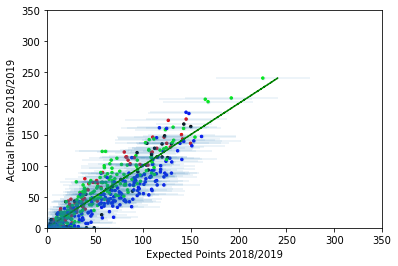

In [167]:
# plot with respect to last seasons points - for those players eligible
y3 = pd.read_csv("../data/players_raw_20182019.csv")
y3['full_name'] = (y3['first_name'] + ' ' + y3['second_name'])
exp_points = np.zeros(len(y3.index))
sd_points = np.zeros(len(y3.index))
cr = np.zeros((len(y3.index), 3))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    exp_points[i] = C[ind]
    sd_points[i] = S[ind]
    cr[i, :] = np.array([((all_players_params.loc[all_players_params.index[ind], 'position'] == 'FWD')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'MID')),
                         ((all_players_params.loc[all_players_params.index[ind], 'position'] == 'DEF'))])

plot.errorbar(exp_points, y3['total_points'] - y3['bonus'], xerr=2 * sd_points, marker='.', linestyle="", alpha=0.1)
plot.scatter(exp_points, y3['total_points'] - y3['bonus'], color=cr, s=6)
plot.plot(y3['total_points'] - y3['bonus'], y3['total_points'] - y3['bonus'], linestyle="--", color='g')
plot.xlim([0, 350])
plot.ylim([0, 350])
plot.xlabel('Expected Points 2018/2019')
plot.ylabel('Actual Points 2018/2019')
plot.show()

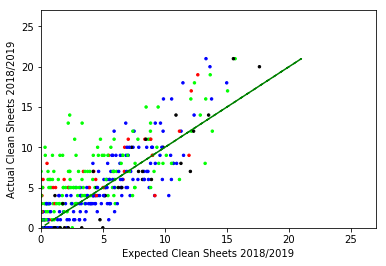

In [168]:
# plot with respect to last seasons clean sheets - for eligble players
clean_sheets = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    clean_sheets[i] = CS[ind]

plot.scatter(clean_sheets, y3['clean_sheets'], color=cr, s=6)
plot.plot(y3['clean_sheets'], y3['clean_sheets'], linestyle="--", color='g')
plot.xlim([0, 27])
plot.ylim([0, 27])
plot.xlabel('Expected Clean Sheets 2018/2019')
plot.ylabel('Actual Clean Sheets 2018/2019')
plot.show()

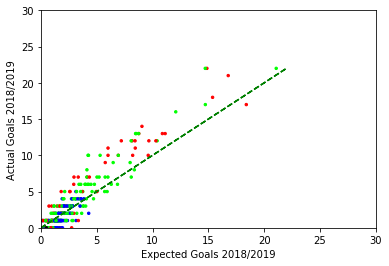

In [171]:
# plot with respect to last seasons goals - for eligble players
goals = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    goals[i] = G[ind]

plot.scatter(goals, y3['goals_scored'], color=cr, s=6)
plot.plot(y3['goals_scored'], y3['goals_scored'], linestyle="--", color='g')
plot.xlim([0, 30])
plot.ylim([0, 30])
plot.xlabel('Expected Goals 2018/2019')
plot.ylabel('Actual Goals 2018/2019')
plot.show()

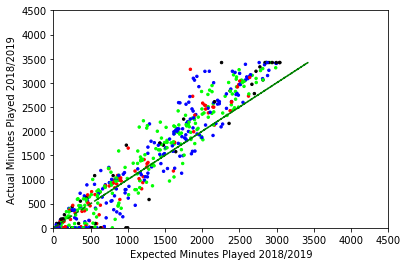

In [172]:
# plot with respect to last seasons mins played - for eligble players
mins_played = np.zeros(len(y3.index))
for i in range(len(y3.index)):
    ind = np.where(y3.loc[y3.index[i], 'full_name'] == all_players_params['player'])[0][0]
    mins_played[i] = MP[ind]

plot.scatter(mins_played, y3['minutes'], s=6, color=cr)
plot.plot(y3['minutes'], y3['minutes'], linestyle="--", color='g')
plot.xlim([0, 4500])
plot.ylim([0, 4500])
plot.xlabel('Expected Minutes Played 2018/2019')
plot.ylabel('Actual Minutes Played 2018/2019')
plot.show()

### Team predictions

Gives predictions for a team's score on a gameweek

In [58]:
# this gameweek fixtures
#fixture_list_this_gw = (pd.read_csv("prem_results_20182019.csv", header=None).as_matrix())[:10, :]
#print(fixture_list_this_gw)

# this gameweek form for each fixture
#form =...

# players for a specific team
tm_players = ['Mohamed Salah', 'James Milner'] #....
new_players_frame = all_players_params[all_players_params['player'].isin(tm_players)]
Niter = 100
C, S = ComputeExpectedPoints(fixture_list_this_gw, form, teams, new_players_frame, all_teams_params,
                             zerooutbottom=3, Niter=Niter)  # zero out bench players
expected_tm_score = np.sum(C)
sd_tm_score = np.sqrt(np.sum(S ** 2))
print('expected team score: ', expected_tm_score)
print('lower 95% confidence team score: ', max(0, expected_tm_score - (2 * sd_tm_score)))
print('upper 95% confidence team score: ', expected_tm_score + (2 * sd_tm_score))

---
Realisation  0
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 2.]  points
---
Realisation  1
Top Points Scorers:  310    Mohamed Salah
298     James Milner
Name: player, dtype: object  with  [2. 5.]  points
---
Realisation  2
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  3
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [ 4. 10.]  points
---
Realisation  4
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [2. 3.]  points
---
Realisation  5
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [0. 3.]  points
---
Realisation  6
Top Points Scorers:  298     James Milner
310    Mohamed Salah
Name: player, dtype: object  with  [1. 2.]  points
---
Realisation  7
Top Points Scorers:  298     James Milner
310   

c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
c:\users\alsgregory\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
# calculates match probability
def match_prob(exp_p1, sd_p1, exp_p2, sd_p2):
    exp_diff = exp_p1 - exp_p2
    sd_diff = np.sqrt((sd_p1 ** 2) + (sd_p2 ** 2))
    return(1 - norm.cdf(0, exp_diff, sd_diff))